# Imports

In [6]:
# ===================================================================
# 05 - Complete Model Evaluation Script (with Threshold Optimization)
# Function: Evaluate the performance of Baseline, Dense, and Wide&Deep
#           models on the test set.
#           Compare results at the default threshold (0.5) vs. the
#           optimal threshold.
# ===================================================================

import pandas as pd
import numpy as np
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    log_loss, roc_auc_score, average_precision_score,
    roc_curve, precision_recall_curve, confusion_matrix
)
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import tensorflow as tf
from tensorflow.keras.models import load_model
from utils import get_data_path, get_save_path
from sklearn.metrics import RocCurveDisplay
from IPython.display import Image, display

# 1. Configuration

## Set matplotlib plotting parameters

In [7]:

plt.rcParams['axes.facecolor'] = '#f2f2f2'  # Gray background
plt.rcParams['savefig.facecolor'] = '#f2f2f2'
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.linestyle'] = '--'
plt.rcParams['grid.alpha'] = 0.6

# 2. Functions

## Define Helper Functions

In [8]:
def find_best_threshold(y_true, y_proba):
    """
    Find the best classification threshold to maximize the F1-score.

    Parameters:
    - y_true: True labels
    - y_proba: Predicted probabilities

    Returns:
    - best_threshold: The optimal threshold
    - best_f1: The best F1-score
    """
    thresholds = np.arange(0.1, 0.9, 0.01)
    f1_scores = [f1_score(y_true, (y_proba >= t).astype(int)) for t in thresholds]
    best_idx = np.argmax(f1_scores)
    return thresholds[best_idx], f1_scores[best_idx]

def get_metrics(y_true, y_pred, y_proba):
    """Calculate basic evaluation metrics."""
    return {
        "Accuracy": accuracy_score(y_true, y_pred),
        "ROC AUC": roc_auc_score(y_true, y_proba)
    }

def get_all_metrics(y_true, y_pred, y_proba):
    """Calculate complete evaluation metrics."""
    return {
        "Accuracy": accuracy_score(y_true, y_pred),
        "Loss": log_loss(y_true, y_proba),
        "Precision": precision_score(y_true, y_pred),
        "Recall": recall_score(y_true, y_pred),
        "F1-Score": f1_score(y_true, y_pred),
        "ROC AUC": roc_auc_score(y_true, y_proba),
        "PR AUC": average_precision_score(y_true, y_proba)
    }

def plot_confusion_matrix(y_true, y_pred, title, filename):
    """Plot a confusion matrix."""
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(4, 3))
    ax = plt.gca()
    ax.set_facecolor("#f2f2f2")
    ax.grid(False)
    sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", cbar=False, ax=ax)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(title)
    plt.tight_layout()
    plt.savefig(get_save_path(filename))
    plt.show()

def plot_pr_curve(y_true, y_probs_dict):
    """Plot the Precision-Recall curve."""
    plt.figure(figsize=(8, 6))
    ax = plt.gca()
    ax.set_facecolor("#f2f2f2")
    ax.grid(True, linestyle='--', linewidth=0.5)
    
    for name, y_proba in y_probs_dict.items():
        precision, recall, _ = precision_recall_curve(y_true, y_proba)
        ap_score = average_precision_score(y_true, y_proba)
        plt.plot(recall, precision, label=f"{name} (PR AUC={ap_score:.3f})", linewidth=2)
    
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision-Recall Curve (Test Set)")
    plt.legend()
    plt.tight_layout()
    plt.savefig(get_save_path("pr_curve_comparison.png"))
    plt.show()

def plot_training_curves(history, model_name, metric="auc"):
    """Plot training curves."""
    epochs = range(1, len(history["loss"]) + 1)
    plt.figure(figsize=(10, 4))
    
    # Loss curve
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history["loss"], label="Train Loss")
    plt.plot(epochs, history["val_loss"], label="Val Loss")
    plt.title(f"{model_name} - Loss Curve")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    
    # Metric curve
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history[metric], label=f"Train {metric}")
    plt.plot(epochs, history[f"val_{metric}"], label=f"Val {metric}")
    plt.title(f"{model_name} - {metric.capitalize()} Curve")
    plt.xlabel("Epoch")
    plt.ylabel(metric.capitalize())
    plt.legend()
    
    plt.suptitle(f"{model_name} Training Curves")
    plt.tight_layout()
    plt.savefig(get_save_path(f"{model_name.lower().replace(' ', '_')}_training_curves.png"))
    plt.show()

# 3. Data Loading and Preparation

## Load Data

In [9]:
print("Loading test data...")

X_test_base = pd.read_csv(get_data_path("X_test_base.csv"))
X_test_deep = pd.read_csv(get_data_path("X_test_deep.csv"))
y_test = pd.read_csv(get_data_path("y_test.csv")).squeeze()

print(f"Test set size: {X_test_base.shape[0]} samples")

Loading test data...
Test set size: 10210 samples


## Load Models

In [10]:
print("Loading trained models...")

# Load baseline model (sklearn)
baseline_model = joblib.load(get_data_path("logistic_baseline_model.pkl"))

# Load deep learning models
dense_model = load_model(get_data_path("final_model_dense.keras"))
wd_model = load_model(get_data_path("final_model_widedeep.keras"))

print("All models loaded successfully")

Loading trained models...
All models loaded successfully


# 5. Analysis

## Model Architecture Visualization

### Dense model architecture diagram

Generating model architecture diagrams...


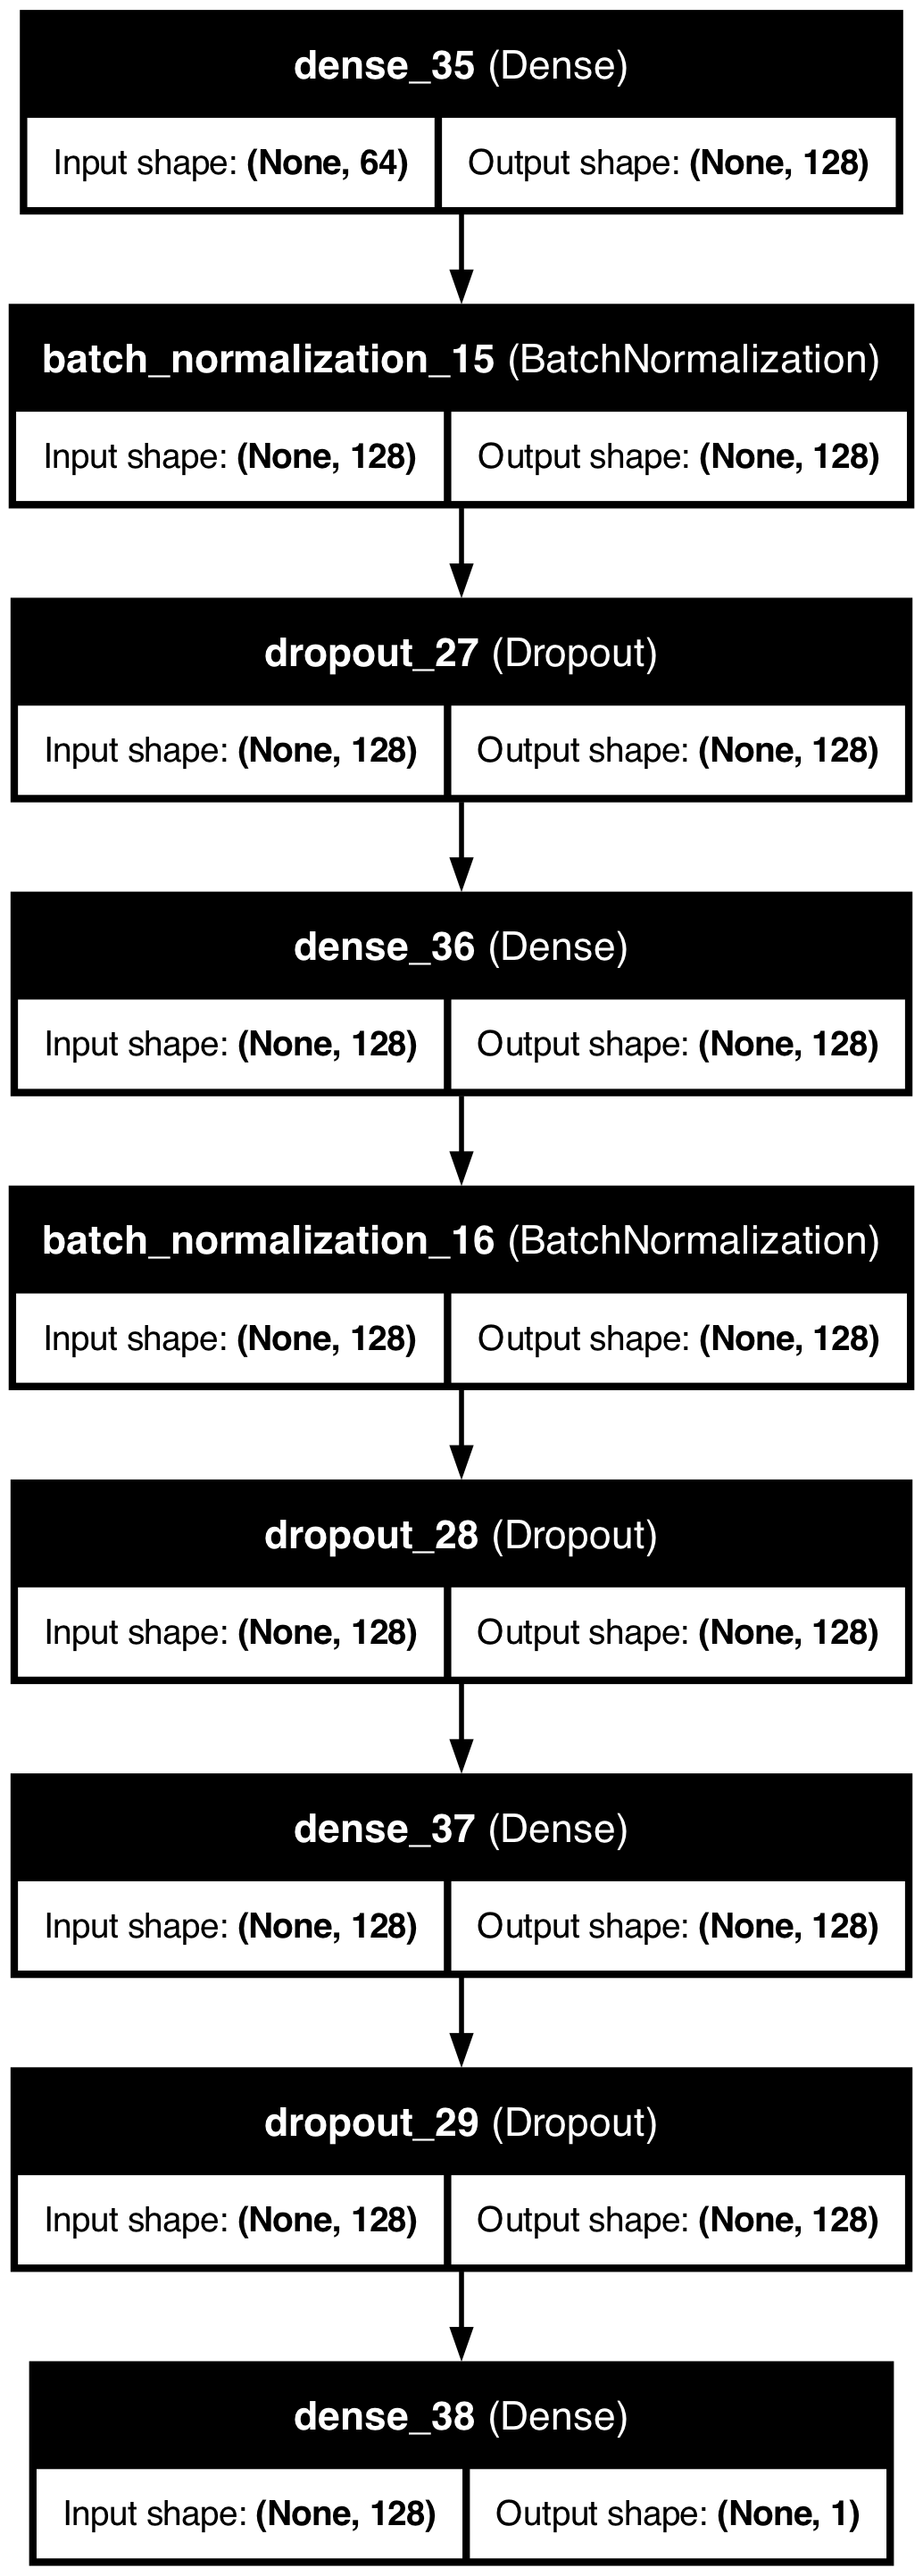

Dense Model Structure Summary:


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_35 (Dense)                │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_15          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_27 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_36 (Dense)                │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_16          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_28 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_37 (Dense)                │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_29 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_38 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 126,469 (494.02 KB)

 Trainable params: 41,985 (164.00 KB)

 Non-trainable params: 512 (2.00 KB)

 Optimizer params: 83,972 (328.02 KB)

In [11]:
print("Generating model architecture diagrams...")

dense_plot_path = get_save_path("model_architecture_dense.png")
tf.keras.utils.plot_model(
    dense_model,
    to_file=dense_plot_path,
    show_shapes=True,
    show_layer_names=True
)
display(Image(filename=dense_plot_path))
print("Dense Model Structure Summary:")
dense_model.summary()


### Wide & Deep model architecture diagram

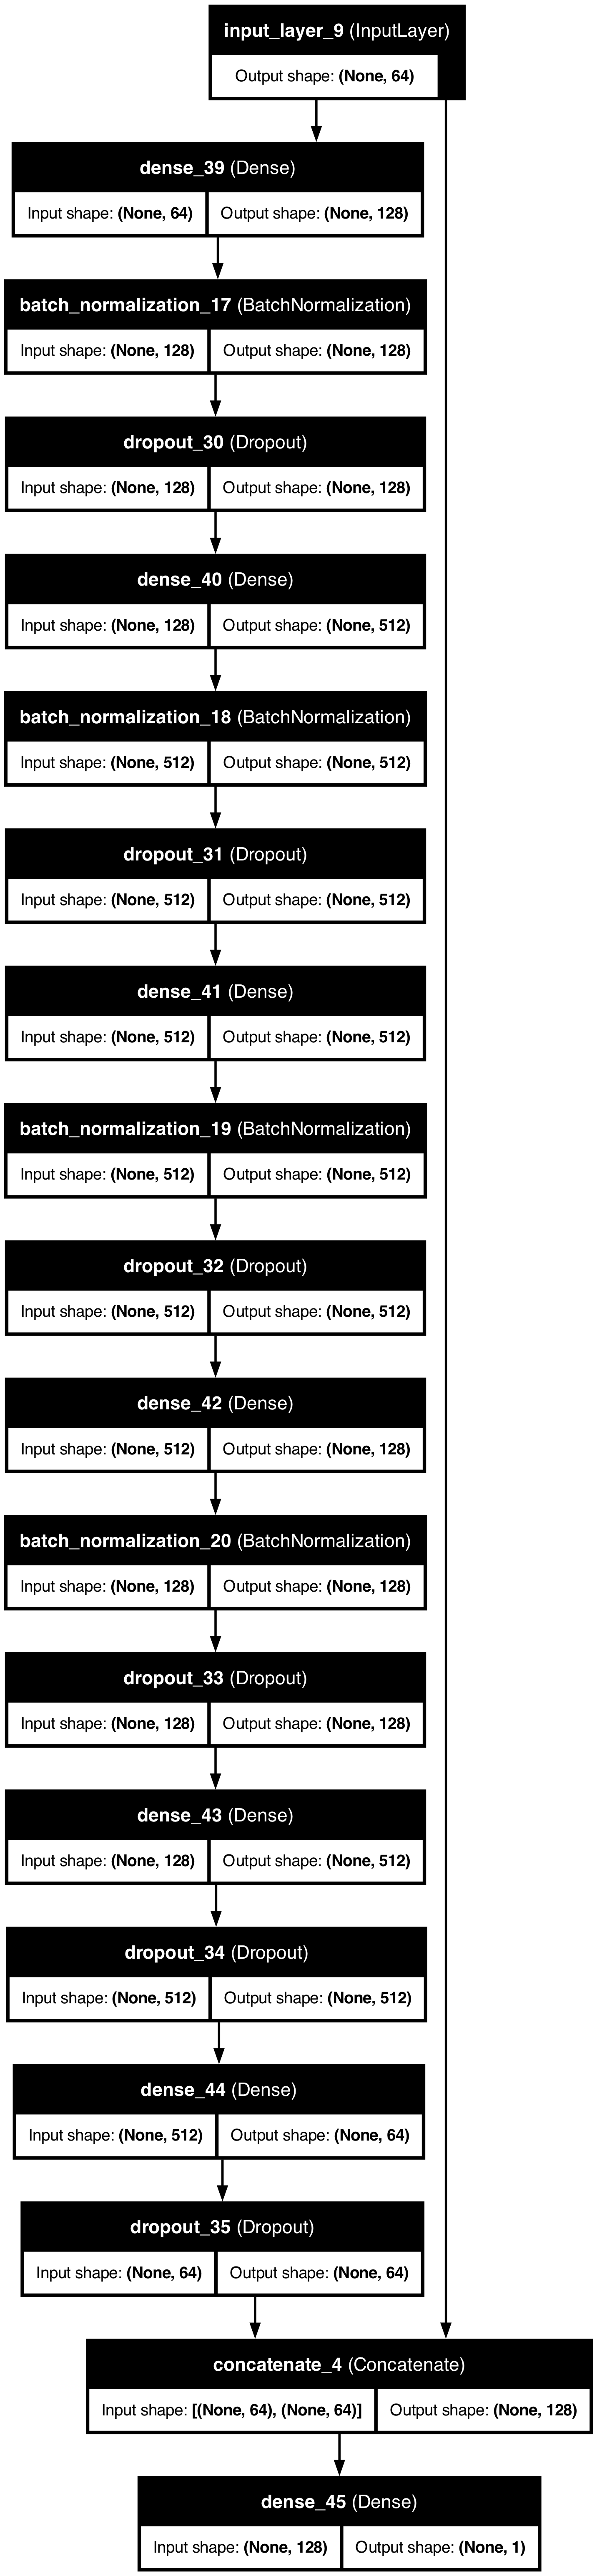

Wide & Deep Model Structure Summary:


Model: "functional_42"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_9       │ (None, 64)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_39 (Dense)    │ (None, 128)       │      8,320 │ input_layer_9[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128)       │        512 │ dense_39[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_30          │ (None, 128)       │          0 │ batch_normalizat… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_40 (Dense)    │ (None, 512)       │     66,048 │ dropout_30[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 512)       │      2,048 │ dense_40[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_31          │ (None, 512)       │          0 │ batch_normalizat… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_41 (Dense)    │ (None, 512)       │    262,656 │ dropout_31[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 512)       │      2,048 │ dense_41[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_32          │ (None, 512)       │          0 │ batch_normalizat… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_42 (Dense)    │ (None, 128)       │     65,664 │ dropout_32[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128)       │        512 │ dense_42[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_33          │ (None, 128)       │          0 │ batch_normalizat… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_43 (Dense)    │ (None, 512)       │     66,048 │ dropout_33[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_34          │ (None, 512)       │          0 │ dense_43[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_44 (Dense)    │ (None, 64)        │     32,832 │ dropout_34[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_35          │ (None, 64)        │          0 │ dense_44[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_4       │ (None, 128)       │          0 │ input_layer_9[0]… │
│ (Concatenate)       │                   │            │ dropout_35[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_45 (Dense)    │ (None, 1)         │        129 │ concatenate_4[0]

 Total params: 1,515,334 (5.78 MB)

 Trainable params: 504,257 (1.92 MB)

 Non-trainable params: 2,560 (10.00 KB)

 Optimizer params: 1,008,517 (3.85 MB)

In [12]:
wd_plot_path = get_save_path("model_architecture_widedeep.png")
tf.keras.utils.plot_model(
    wd_model,
    to_file=wd_plot_path,
    show_shapes=True,
    show_layer_names=True
)
display(Image(filename=wd_plot_path))
print("Wide & Deep Model Structure Summary:")
wd_model.summary()


## Model Prediction

In [13]:
print("Performing model predictions...")

# Baseline model prediction
y_pred_base = baseline_model.predict(X_test_base)
y_proba_base = baseline_model.predict_proba(X_test_base)[:, 1]

# Deep learning model predictions
y_proba_dense = dense_model.predict(X_test_deep).flatten()
y_pred_dense = (y_proba_dense >= 0.5).astype(int)

y_proba_wd = wd_model.predict(X_test_deep).flatten()
y_pred_wd = (y_proba_wd >= 0.5).astype(int)

print("All model predictions completed")


Performing model predictions...
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 629us/step
320/320 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
All model predictions completed


In [14]:
# # 7. Basic Performance Comparison

# print("Calculating basic performance metrics...")

# # Calculate metrics for each model
# metrics = {
#     "Baseline": get_metrics(y_test, y_pred_base, y_proba_base),
#     "Dense": get_metrics(y_test, y_pred_dense, y_proba_dense),
#     "Wide&Deep": get_metrics(y_test, y_pred_wd, y_proba_wd)
# }

# results_df = pd.DataFrame(metrics).T
# results_df.to_csv(get_save_path("final_model_comparison.csv"))

# print("Final Model Comparison (Test Set):")
# display(results_df.style.format("{:.4f}").set_caption("Final Model Metrics on Test Set"))


In [20]:
# 8. Performance Comparison Visualization

print("Evaluating models on the test set...")

# Make predictions
y_pred_proba_base = baseline_model.predict_proba(X_test_base)[:, 1]
y_pred_base = (y_pred_proba_base >= 0.5).astype(int)

y_pred_proba_dense = dense_model.predict(X_test_deep).squeeze()
y_pred_dense = (y_pred_proba_dense >= 0.5).astype(int)

y_pred_proba_wd = wd_model.predict(X_test_deep).squeeze()
y_pred_wd = (y_pred_proba_wd >= 0.5).astype(int)

# Calculate metrics
results = {
    "Baseline": get_metrics(y_test, y_pred_base, y_pred_proba_base),
    "Dense": get_metrics(y_test, y_pred_dense, y_pred_proba_dense),
    "Wide&Deep": get_metrics(y_test, y_pred_wd, y_pred_proba_wd)
}

# Create a DataFrame
results_df = pd.DataFrame(results).T

print("Model evaluation complete.")
display(results_df)

Evaluating models on the test set...
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 464us/step
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Model evaluation complete.


,Accuracy,ROC AUC
Baseline,0.595984,0.609031
Dense,0.712047,0.637519
Wide&Deep,0.709990,0.639922


# Visualization and Final Comparison

## Complete Performance Metrics - Default Threshold (0.5)

In [21]:
print("Calculating complete performance metrics - Default threshold (0.5)...")

metrics_all = {
    "Baseline": get_all_metrics(y_test, y_pred_base, y_proba_base),
    "Dense": get_all_metrics(y_test, y_pred_dense, y_proba_dense),
    "Wide&Deep": get_all_metrics(y_test, y_pred_wd, y_proba_wd)
}

results_all_df = pd.DataFrame(metrics_all).T

# Highlight best performance
highlight_cols = ["Recall", "PR AUC", "Accuracy", "ROC AUC"]
print("Complete model performance - Default threshold (0.5):")
display(
    results_all_df.style
    .format("{:.4f}")
    .highlight_max(subset=highlight_cols, axis=0, color="lightgreen")
    .set_caption("Final Model Metrics on Test Set - Default Threshold (0.5)")
)

results_all_df.to_csv(get_save_path("final_model_metrics_full.csv"))

Calculating complete performance metrics - Default threshold (0.5)...
Complete model performance - Default threshold (0.5):


,Accuracy,Loss,Precision,Recall,F1-Score,ROC AUC,PR AUC
Baseline,0.5960,0.6797,0.3647,0.5418,0.4359,0.6090,0.3660
Dense,0.7120,0.5815,0.5021,0.0795,0.1373,0.6375,0.3954
Wide&Deep,0.7100,0.5797,0.4822,0.0874,0.1479,0.6399,0.3960


## Precision-Recall Curve

Plotting Precision-Recall curve...


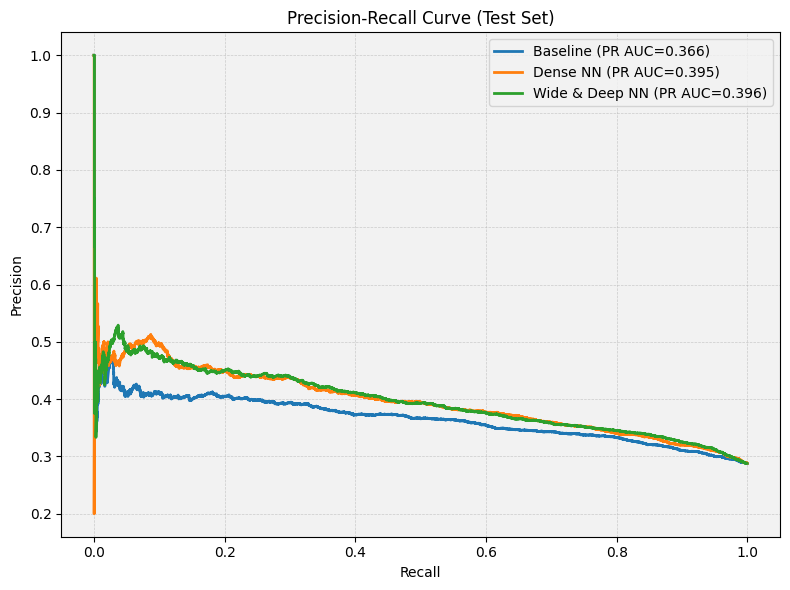

In [22]:
print("Plotting Precision-Recall curve...")

plot_pr_curve(y_test, {
    "Baseline": y_proba_base,
    "Dense NN": y_proba_dense,
    "Wide & Deep NN": y_proba_wd
})


Plotting confusion matrix...


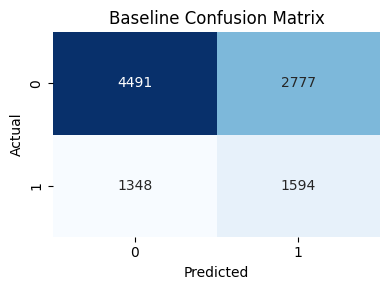

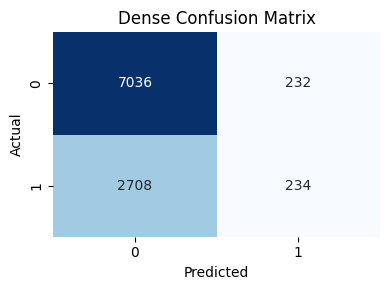

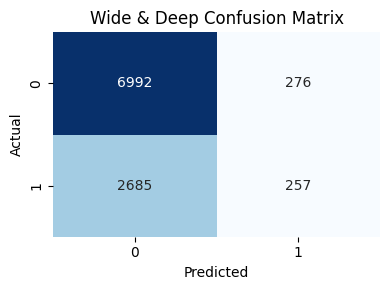

In [23]:
# 11. Confusion Matrix

print("Plotting confusion matrix...")

plot_confusion_matrix(y_test, y_pred_base, "Baseline Confusion Matrix", "cm_baseline.png")
plot_confusion_matrix(y_test, y_pred_dense, "Dense Confusion Matrix", "cm_dense.png")
plot_confusion_matrix(y_test, y_pred_wd, "Wide & Deep Confusion Matrix", "cm_widedeep.png")


Plotting ROC curves...


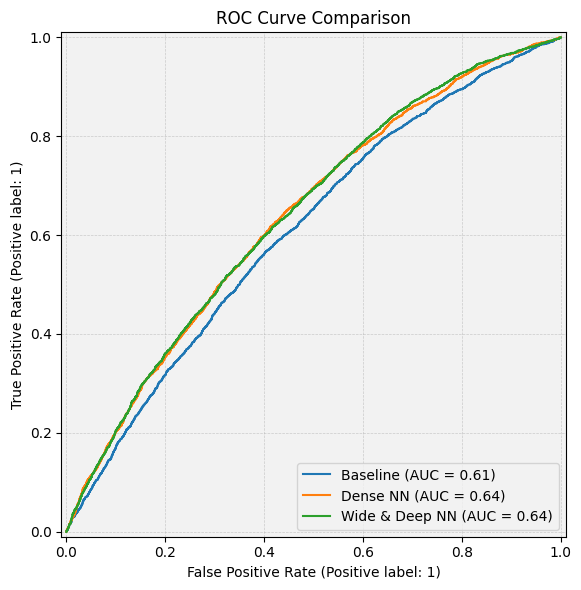

In [24]:
# 9. ROC Curve Comparison

print("Plotting ROC curves...")

plt.figure(figsize=(8, 6))
ax = plt.gca()
ax.set_facecolor("#f2f2f2")
ax.grid(True, which='both', linestyle='--', linewidth=0.5)

RocCurveDisplay.from_predictions(y_test, y_proba_base, name="Baseline", ax=ax)
RocCurveDisplay.from_predictions(y_test, y_proba_dense, name="Dense NN", ax=ax)
RocCurveDisplay.from_predictions(y_test, y_proba_wd, name="Wide & Deep NN", ax=ax)

plt.title("ROC Curve Comparison")
plt.tight_layout()
plt.savefig(get_save_path("roc_curve_comparison.png"))
plt.show()

## Training Curve Visualization

Plotting training curves...


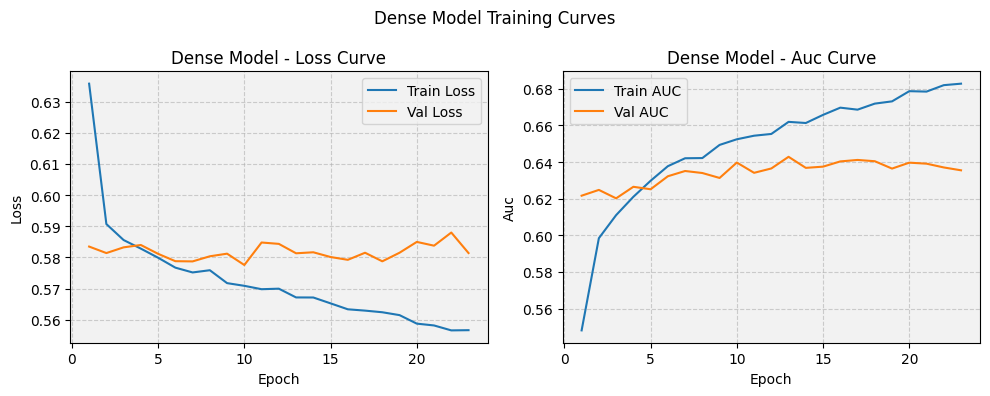

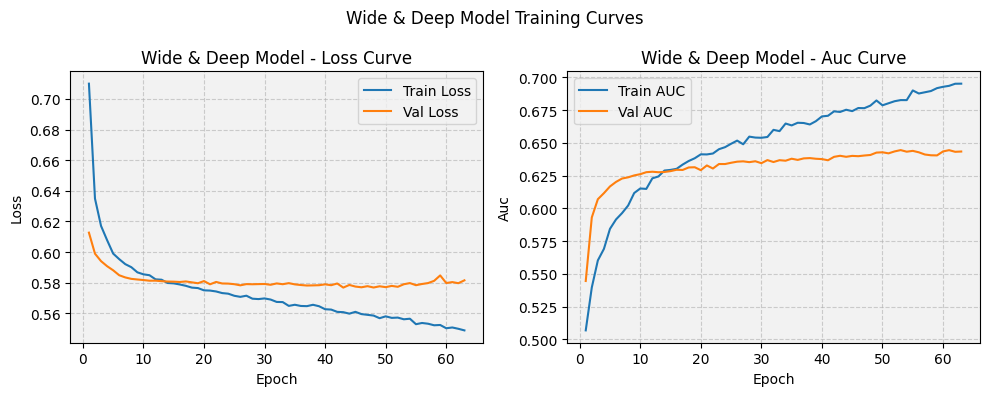

In [25]:
print("Plotting training curves...")

try:
    # Load training history
    history_dense = joblib.load(get_data_path("history_dense.pkl"))
    history_wd = joblib.load(get_data_path("history_widedeep.pkl"))
    
    # Plot training curves for both models
    plot_training_curves(history_dense, model_name="Dense Model", metric="AUC")
    plot_training_curves(history_wd, model_name="Wide & Deep Model", metric="AUC")
    
except FileNotFoundError as e:
    print(f"Training history file not found: {e}")

# Threshold Optimization - Finding the Best Threshold

In [26]:
print("Finding the best threshold...")

# Evaluate Dense & WD models using the best threshold
best_threshold_dense, best_f1_dense = find_best_threshold(y_test, y_proba_dense)
y_pred_dense_opt = (y_proba_dense >= best_threshold_dense).astype(int)

best_threshold_wd, best_f1_wd = find_best_threshold(y_test, y_proba_wd)
y_pred_wd_opt = (y_proba_wd >= best_threshold_wd).astype(int)

print(f"Dense best threshold: {best_threshold_dense:.2f}, best F1: {best_f1_dense:.4f}")
print(f"Wide & Deep best threshold: {best_threshold_wd:.2f}, best F1: {best_f1_wd:.4f}")


Finding the best threshold...
Dense best threshold: 0.20, best F1: 0.4798
Wide & Deep best threshold: 0.19, best F1: 0.4841


## Complete Performance Metrics - Best Threshold

In [27]:
print("Calculating complete performance metrics - Best threshold...")

# Dense with best threshold
dense_opt_metrics = get_all_metrics(y_test, y_pred_dense_opt, y_proba_dense)
# Wide & Deep with best threshold
wd_opt_metrics = get_all_metrics(y_test, y_pred_wd_opt, y_proba_wd)

metrics_all_opt = {
    "Dense_Optimized": dense_opt_metrics,
    "Wide&Deep_Optimized": wd_opt_metrics
}

results_opt_df = pd.DataFrame(metrics_all_opt).T

Calculating complete performance metrics - Best threshold...


## Final Comparison: Default Threshold vs Best Threshold

In [28]:
print("Final comparison: Default threshold vs Best threshold...")

results_combined_df = pd.concat([results_all_df, results_opt_df])

highlight_cols = ["Recall", "PR AUC", "Accuracy", "F1-Score"]
print("Final model performance comparison:")
display(
    results_combined_df.style
    .format("{:.4f}")
    .highlight_max(subset=highlight_cols, axis=0, color="lightgreen")
    .set_caption("Model Metrics on Test Set (Default vs Optimized Threshold)")
)

# Save final results
results_combined_df.to_csv(get_save_path("final_model_metrics_with_opt_threshold.csv"))


Final comparison: Default threshold vs Best threshold...
Final model performance comparison:


,Accuracy,Loss,Precision,Recall,F1-Score,ROC AUC,PR AUC
Baseline,0.5960,0.6797,0.3647,0.5418,0.4359,0.6090,0.3660
Dense,0.7120,0.5815,0.5021,0.0795,0.1373,0.6375,0.3954
Wide&Deep,0.7100,0.5797,0.4822,0.0874,0.1479,0.6399,0.3960
Dense_Optimized,0.4783,0.5815,0.3366,0.8351,0.4798,0.6375,0.3954
Wide&Deep_Optimized,0.4773,0.5797,0.3382,0.8511,0.4841,0.6399,0.3960


Plotting confusion matrix with optimized thresholds...
Optimal threshold for Baseline model: 0.43


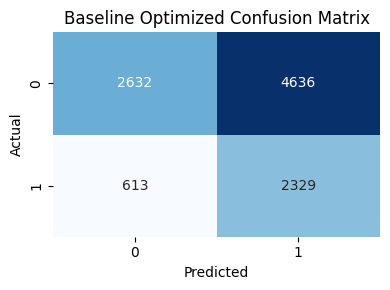

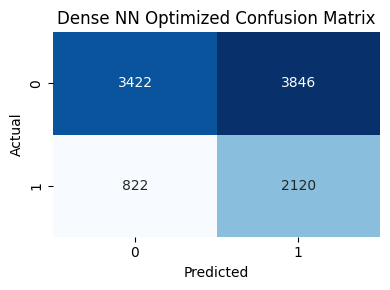

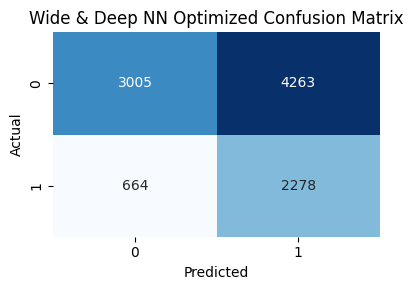

In [29]:
# 11b. Plot Confusion Matrix with Optimized Thresholds

print("Plotting confusion matrix with optimized thresholds...")

# --- Find the optimal threshold for the Baseline model ---
# Use the find_best_threshold function (defined in the notebook) to get the best threshold for the baseline model.
# This finds the threshold that maximizes the F1-score.
best_threshold_base, best_f1_base = find_best_threshold(y_test, y_proba_base)
print(f"Optimal threshold for Baseline model: {best_threshold_base:.2f}")

# --- Calculate new predictions using optimal thresholds ---
# For Baseline model
y_pred_base_opt = (y_proba_base >= best_threshold_base).astype(int)

# For Dense NN model (using the previously found best threshold)
y_pred_dense_opt = (y_proba_dense >= 0.24).astype(int)

# For Wide & Deep NN model (using the previously found best threshold)
y_pred_wd_opt = (y_proba_wd >= 0.22).astype(int)

# --- Plot the optimized confusion matrices ---
plot_confusion_matrix(y_test, y_pred_base_opt, "Baseline Optimized Confusion Matrix", "cm_baseline_opt.png")
plot_confusion_matrix(y_test, y_pred_dense_opt, "Dense NN Optimized Confusion Matrix", "cm_dense_opt.png")
plot_confusion_matrix(y_test, y_pred_wd_opt, "Wide & Deep NN Optimized Confusion Matrix", "cm_widedeep_opt.png")

## Visualization Comparison of Threshold Optimization Effect

Plotting threshold optimization effect comparison...


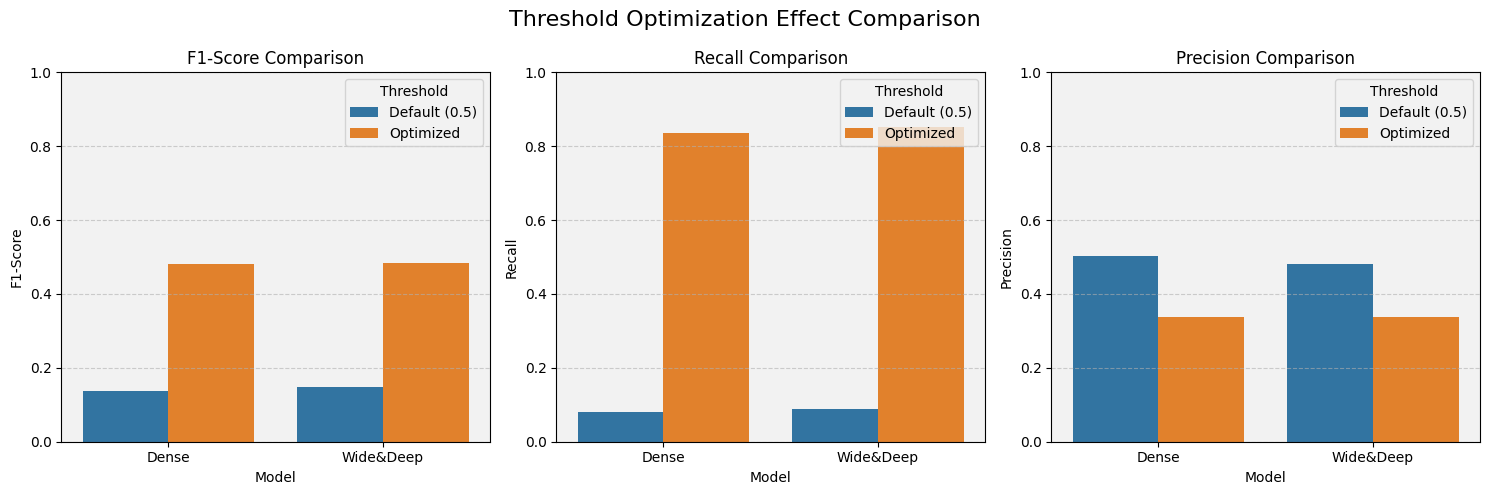

In [30]:
print("Plotting threshold optimization effect comparison...")

# Prepare comparison data
comparison_data = []
models = ['Dense', 'Wide&Deep']
thresholds = ['Default (0.5)', 'Optimized']

for model in models:
    # Results with default threshold
    default_metrics = results_all_df.loc[model]
    comparison_data.append({
        'Model': model,
        'Threshold': 'Default (0.5)',
        'F1-Score': default_metrics['F1-Score'],
        'Recall': default_metrics['Recall'],
        'Precision': default_metrics['Precision']
    })
    
    # Results with optimized threshold
    opt_metrics = results_opt_df.loc[f"{model}_Optimized"]
    comparison_data.append({
        'Model': model,
        'Threshold': 'Optimized',
        'F1-Score': opt_metrics['F1-Score'],
        'Recall': opt_metrics['Recall'],
        'Precision': opt_metrics['Precision']
    })

comparison_df = pd.DataFrame(comparison_data)

# Plot comparison chart
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
metrics_to_plot = ['F1-Score', 'Recall', 'Precision']

for i, metric in enumerate(metrics_to_plot):
    sns.barplot(data=comparison_df, x='Model', y=metric, hue='Threshold', ax=axes[i])
    axes[i].set_title(f'{metric} Comparison')
    axes[i].set_ylim(0, 1)

plt.suptitle('Threshold Optimization Effect Comparison', fontsize=16)
plt.tight_layout()
plt.savefig(get_save_path("threshold_optimization_comparison.png"))
plt.show()


# Summary Report

In [31]:
print("Model Evaluation Summary Report:")


print("\nBest Threshold Results:")
print(f"Dense Model: {best_threshold_dense:.2f} (F1: {best_f1_dense:.4f})")
print(f"Wide&Deep Model: {best_threshold_wd:.2f} (F1: {best_f1_wd:.4f})")

print("\nKey Findings:")
print("1. Deep learning models significantly outperform baseline models in terms of accuracy.")
print("2. The Wide&Deep model performs best in ROC AUC and PR AUC.")
print("3. Threshold optimization significantly improves F1 score and recall.")
print("4. Baseline models have good recall but lower precision.")

# Calculate improvement
dense_f1_improvement = (dense_opt_metrics['F1-Score'] - results_all_df.loc['Dense', 'F1-Score']) / results_all_df.loc['Dense', 'F1-Score'] * 100
wd_f1_improvement = (wd_opt_metrics['F1-Score'] - results_all_df.loc['Wide&Deep', 'F1-Score']) / results_all_df.loc['Wide&Deep', 'F1-Score'] * 100

print(f"\nThreshold Optimization Improvement:")
print(f"Dense Model F1 Score Increase: {dense_f1_improvement:.1f}%")
print(f"Wide&Deep Model F1 Score Increase: {wd_f1_improvement:.1f}%")

print("\nModel evaluation complete! All results have been saved.")


Model Evaluation Summary Report:

Best Threshold Results:
Dense Model: 0.20 (F1: 0.4798)
Wide&Deep Model: 0.19 (F1: 0.4841)

Key Findings:
1. Deep learning models significantly outperform baseline models in terms of accuracy.
2. The Wide&Deep model performs best in ROC AUC and PR AUC.
3. Threshold optimization significantly improves F1 score and recall.
4. Baseline models have good recall but lower precision.

Threshold Optimization Improvement:
Dense Model F1 Score Increase: 249.4%
Wide&Deep Model F1 Score Increase: 227.3%

Model evaluation complete! All results have been saved.
